In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
from dask import delayed, compute
import itertools
from pytmatrix import tmatrix_aux, refractive, tmatrix, radar
from pymiecoated import Mie
from scipy.constants import c
from scipy import stats as ss
from sqlalchemy.exc import OperationalError
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from re import split
import matplotlib.dates as mdates
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import dask.dataframe as dd
from dask import delayed, compute
from metpy.calc import pressure_to_height_std as p2h
from metpy.calc import lcl
import cartopy.crs as ccrs
import cartopy
import cartopy.mpl.ticker as cticker
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings('ignore')
# from matplotlib import pyplot
# pyplot.style.use('dark_background')
# pyplot.style.use('seaborn')
# pyplot.style.use('ggplot')


sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask/dataframe/backends.py:181: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask/dataframe/backends.py:181: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask/dataframe/backends.py:181: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Floa

In [2]:
def bcksct(ds, instrument, ar=1, j=0) -> pd.DataFrame:
    """

    :param ds: numpy array of particle diameters. should be in millimeters
    :param ar: axis ratio of the particle
    :param j: Zenith angle input
    :return:
    """
    x_ku = 2 * np.pi * (ds / 2.) / tmatrix_aux.wl_Ku
    x_ka = 2 * np.pi * (ds / 2.) / tmatrix_aux.wl_Ka
    x_w = 2 * np.pi * (ds / 2.) / tmatrix_aux.wl_W
    # Tmatrix calculations
    tmat_ku = [radar.radar_xsect(tmatrix.Scatterer(radius=i / 2., wavelength=tmatrix_aux.wl_Ku,
                                                   m=refractive.m_w_0C[tmatrix_aux.wl_Ku], axis_ratio=1.0 / ar, thet0=j,
                                                   thet=180 - j,
                                                   phi0=0., phi=180., radius_type=tmatrix.Scatterer.RADIUS_MAXIMUM)) for
               i in ds]
    tmat_ka = [radar.radar_xsect(tmatrix.Scatterer(radius=i / 2., wavelength=tmatrix_aux.wl_Ka,
                                                   m=refractive.m_w_0C[tmatrix_aux.wl_Ka], axis_ratio=1.0 / ar, thet0=j,
                                                   thet=180 - j,
                                                   phi0=0., phi=180., radius_type=tmatrix.Scatterer.RADIUS_MAXIMUM)) for
               i in ds]
    tmat_w = [radar.radar_xsect(tmatrix.Scatterer(radius=i / 2., wavelength=tmatrix_aux.wl_W,
                                                  m=refractive.m_w_0C[tmatrix_aux.wl_W], axis_ratio=1.0 / ar, thet0=j,
                                                  thet=180 - j,
                                                  phi0=0., phi=180., radius_type=tmatrix.Scatterer.RADIUS_MAXIMUM)) for
              i in ds]

    # Mie calculations
    mie_ku = [Mie(x=x_ku[w], m=refractive.m_w_0C[tmatrix_aux.wl_Ku]).qb() * np.pi * (i / 2.) ** 2 for w, i in
              enumerate(ds)]
    mie_ka = [Mie(x=x_ka[w], m=refractive.m_w_0C[tmatrix_aux.wl_Ka]).qb() * np.pi * (i / 2.) ** 2 for w, i in
              enumerate(ds)]
    mie_w = [Mie(x=x_w[w], m=refractive.m_w_0C[tmatrix_aux.wl_W]).qb() * np.pi * (i / 2.) ** 2 for w, i in
             enumerate(ds)]
    df_scatter = pd.DataFrame(
        {'T_mat_Ku': tmat_ku, 'T_mat_Ka': tmat_ka, 'T_mat_W': tmat_w, 'Mie_Ku': mie_ku, 'Mie_Ka': mie_ka,
         'Mie_W': mie_w}, index=ds)
    path_db = f'{path_data}/db'
    str_db = f"sqlite:///{path_db}/backscatter.sqlite"
    df_scatter.to_sql(f'{instrument}', con=str_db, if_exists='replace')
    return df_scatter


def ref_calc(xr_data, mie=False):
    ds = xr_data.diameter.values / 1e3
    try:
        path_db = f'{path_data}/db'
        make_dir(path_db)
        str_db = f"sqlite:///{path_db}/backscatter.sqlite"
        backscatter = pd.read_sql(f"{xr_data.attrs['instrument']}", con=str_db)
    except OperationalError:
        backscatter = bcksct(ds, xr_data.attrs['instrument'])

    ku_wvl = c / 14e9 * 1000
    ka_wvl = c / 35e9 * 1000
    w_wvl = c / 95e9 * 1000
    bcks = xr.Dataset.from_dataframe(backscatter).rename_dims({'index': 'diameter'}).rename({'index': 'diameter'})

    if mie:
        z_ku = (ku_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.Mie_Ku * xr_data.psd * 1e6 * xr_data.d_d
        z_ka = (ka_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.Mie_Ka * xr_data.psd * 1e6 * xr_data.d_d
        z_w = (w_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.Mie_W * xr_data.psd * 1e6 * xr_data.d_d
    else:
        z_ku = (ku_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.T_mat_Ku * xr_data.psd * 1e6 * xr_data.d_d / 1e3
        z_ka = (ka_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.T_mat_Ka * xr_data.psd * 1e6 * xr_data.d_d / 1e3
        z_w = (w_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.T_mat_W * xr_data.psd * 1e6 * xr_data.d_d / 1e3
        
    ref = z_ka.to_dataset(name='z_ka')
    ref['z_ku'] = z_ku
    ref['z_w'] = z_w
    return ref

def pds_parameters(xr_data):
    """
    Compute the psd parameters
    :param xr_data: partice size distribution in # L-1 um-1
    :return: list with lwc, dm, nw, z, and r
    """
    lwc = (np.pi / (6 * 1000.)) * (xr_data.psd * 1e6) * (xr_data.diameter * 1e-3) ** 3 * (xr_data.d_d * 1e-3)
    m4 = (xr_data.psd * 1e6) * (xr_data.diameter * 1e-3) ** 4 * xr_data.d_d * 1e-3
    m3 = (xr_data.psd * 1e6) * (xr_data.diameter * 1e-3) ** 3 * xr_data.d_d * 1e-3
    dm = m4.sum('diameter') / m3.sum('diameter')
    z = xr_data.psd * 1e6 * (xr_data.diameter * 1e-3) ** 6 * xr_data.d_d
    nw = 1e3 * (4 ** 4 / np.pi) * (lwc.sum('diameter') / dm ** 4)
    params = lwc.to_dataset(name='lwc')
    params['dm'] = dm
    params['z'] = z
    params['nw'] = nw
    return params

def add_colorbar_outside(im, ax, label):
    fig = ax.get_figure()
    bbox = ax.get_position() #bbox contains the [x0 (left), y0 (bottom), x1 (right), y1 (top)] of the axis.
    width = 0.01
    eps = 0.05 #margin between plot and colorbar
    # [left most position, bottom position, width, height] of color bar.
    cax = fig.add_axes([bbox.x1 + eps, bbox.y0, width, bbox.height])
    cbar = fig.colorbar(im, cax=cax, label=label)
    

In [3]:
cdict = {'red': ((0., 1, 1),
                 (0.05, 1, 1),
                 (0.11, 0, 0),
                 (0.66, 1, 1),
                 (0.89, 1, 1),
                 (1, 0.5, 0.5)),
         'green': ((0., 1, 1),
                   (0.05, 1, 1),
                   (0.11, 0, 0),
                   (0.375, 1, 1),
                   (0.64, 1, 1),
                   (0.91, 0, 0),
                   (1, 0, 0)),
         'blue': ((0., 1, 1),
                  (0.05, 1, 1),
                  (0.11, 1, 1),
                  (0.34, 1, 1),
                  (0.65, 0, 0),
                  (1, 0, 0))}

my_cmap = LinearSegmentedColormap('my_colormap', cdict, 256)

In [4]:
cluster = SLURMCluster(queue="seseml",
                       memory='10GB',
                       cores=40,
                       processes=1,
                       walltime='24:00:00',
                       scheduler_options={'host': '172.22.179.3:7223', 'dashboard_address': ':7799'})

cluster.scale(jobs=4)
cluster

In [5]:
client = Client(cluster)
client

Client Scheduler: tcp://172.22.179.3:7223 Dashboard: /proxy/7799/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
%%bash
squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            963164    seseml dask-wor alfonso8 PD       0:00      1 (None)
            963163    seseml dask-wor alfonso8 PD       0:00      1 (None)
            963161    seseml dask-wor alfonso8  R       0:00      1 keeling-j17
            963162    seseml dask-wor alfonso8  R       0:00      1 keeling-j18


In [7]:
# # rdm_idx = pd.date_range(start='2019-09-06 23:58:30', periods=60, tz='UTC', freq='S')  # for P3B
# # rdm_idx = pd.date_range(start='2019-09-07 2:31:45', periods=150, tz='UTC', freq='S')  # for Lear
# start = '2019-09-07 02:31:45'
# end = '2019-09-07 02:33:30'
aircraft = 'Lear'
aircraft2 = 'Learjet'

In [8]:
store1 = f"{path_data}/zarr/combined_psd_{aircraft}_350_825.zarr"
store2 = f"{path_data}/zarr/combined_psd_{aircraft}_800_1200.zarr"
store3 = f"{path_data}/zarr/2DS10_{aircraft2}.zarr"
store4 = f"{path_data}/zarr/HVPS_{aircraft2}.zarr"
store5 = f"{path_data}/zarr/Page0_Learjet.zarr"
store6 = f"{path_data}/zarr/FFSSP_{aircraft2}.zarr"
store7 = f"{path_data}/zarr/FCDP_{aircraft2}.zarr"

In [10]:
xr_comb_350 = xr.open_zarr(store1)
xr_comb_800 = xr.open_zarr(store2)
xr_2ds = xr.open_zarr(store3)#.resample(time='5S').mean()
xr_hvps = xr.open_zarr(store4)#.resample(time='5S').mean()
xr_fssp = xr.open_zarr(store6)#.resample(time='5S').mean()
xr_fcdp = xr.open_zarr(store7)#.resample(time='5S').mean()
xr_add = xr.open_zarr(store5)#.resample(time='5S').mean()

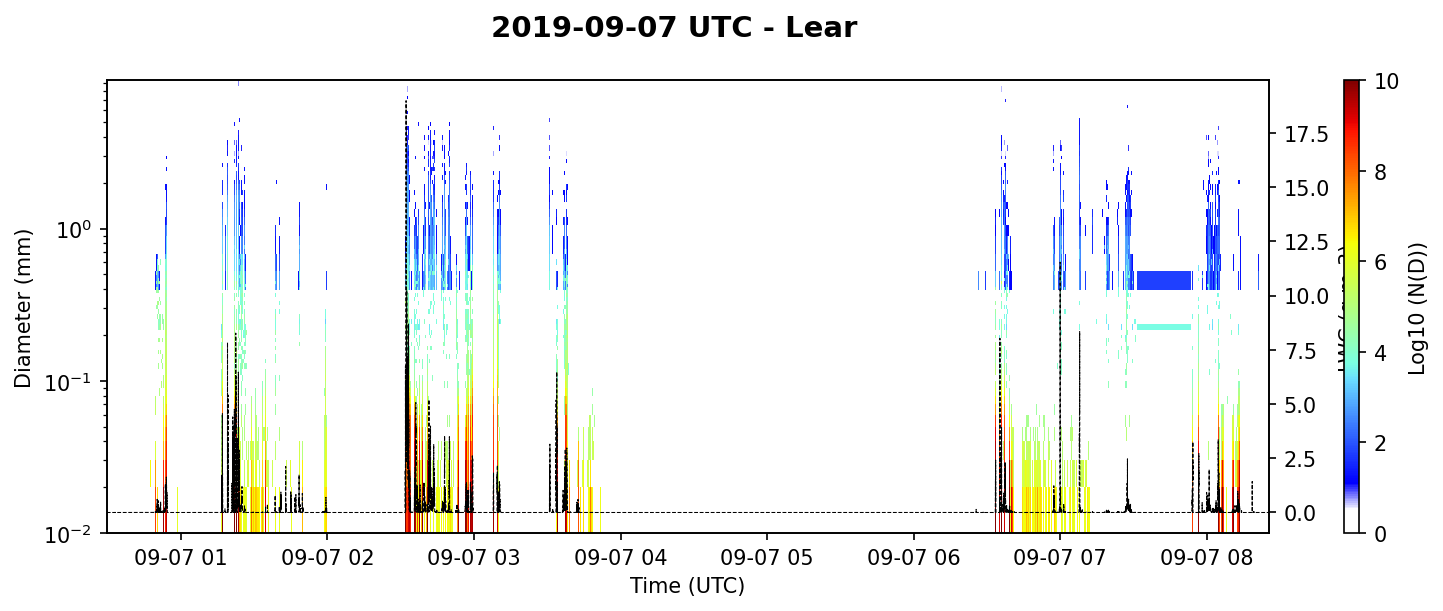

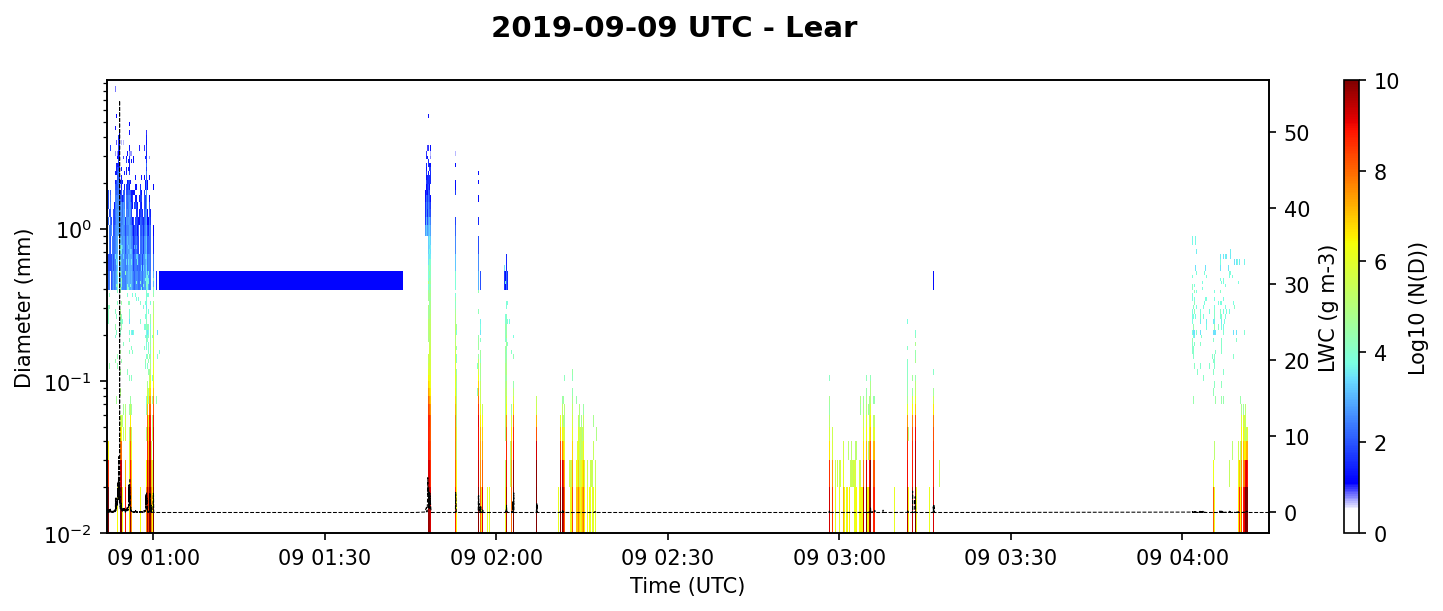

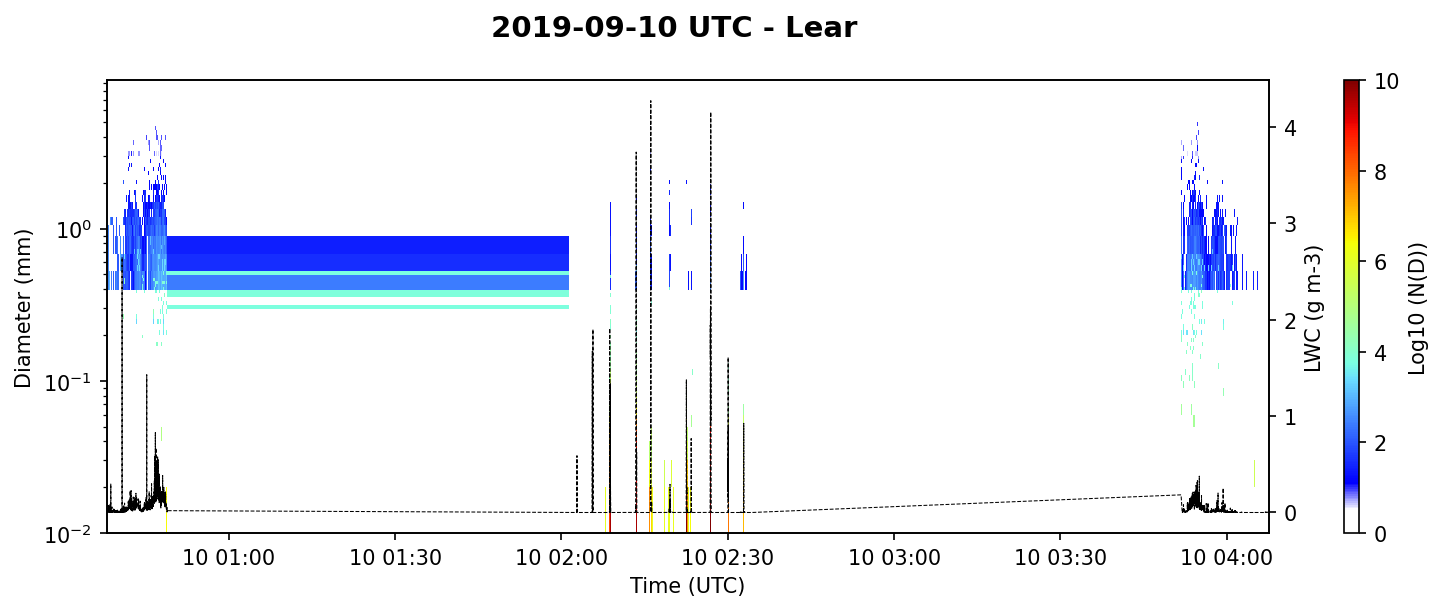

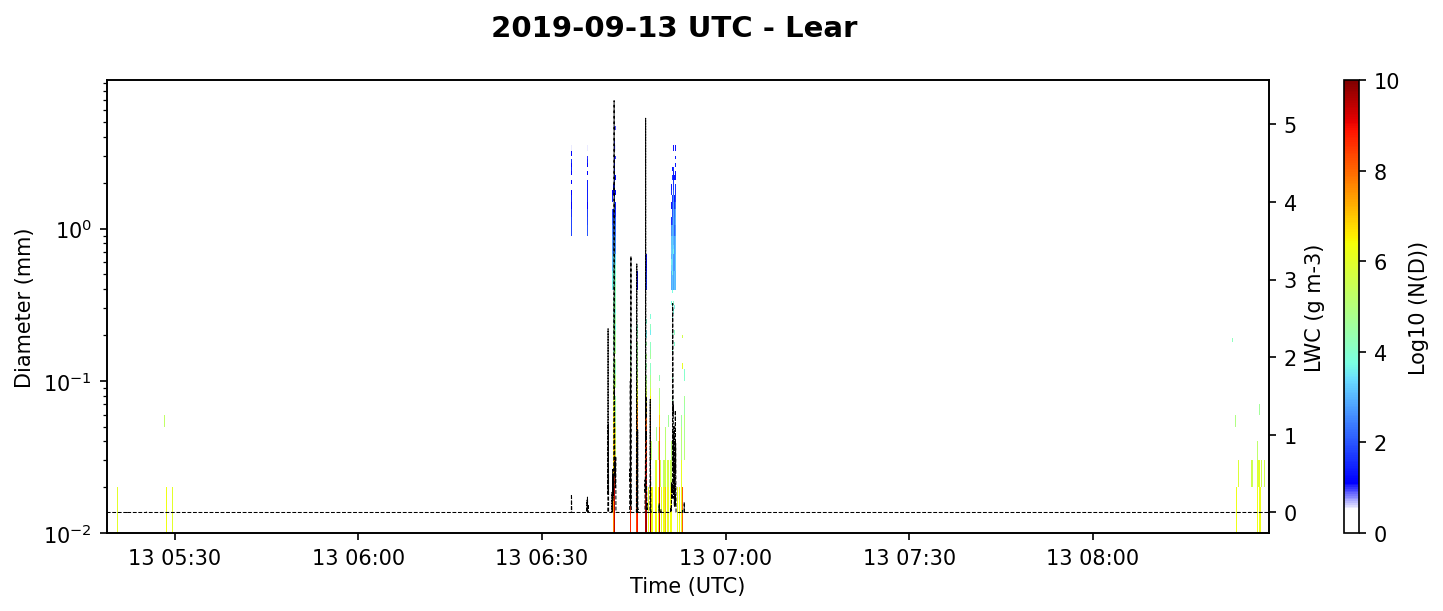

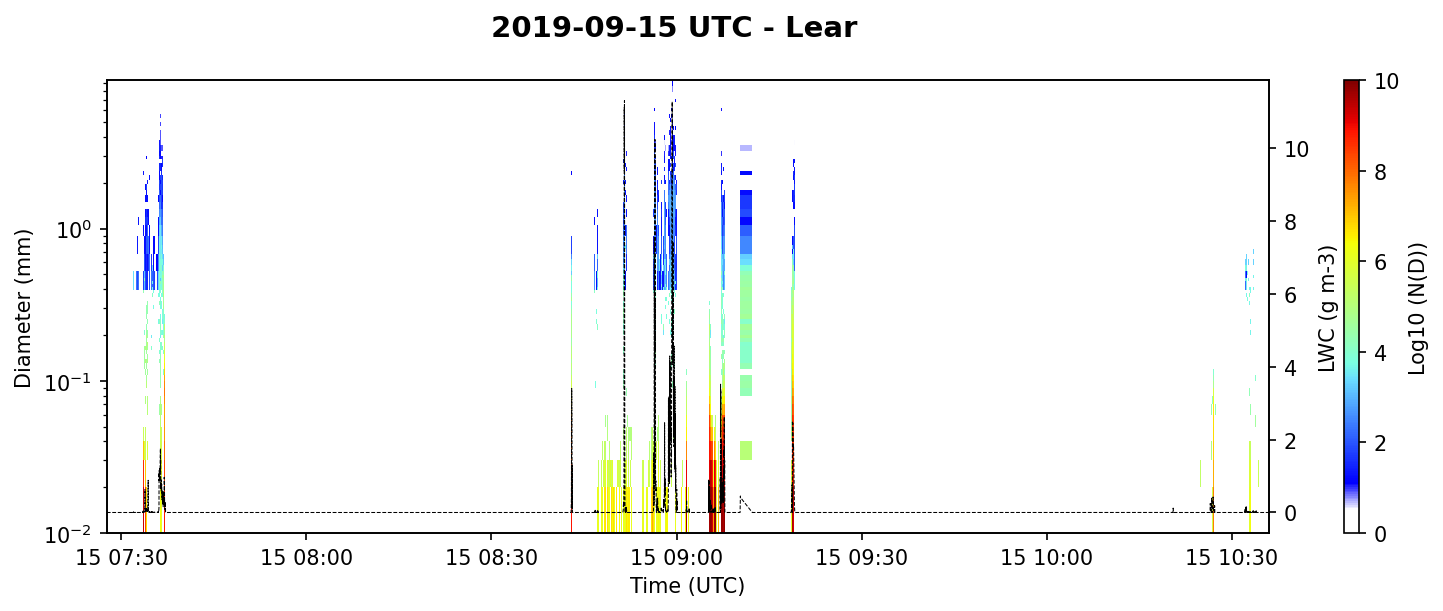

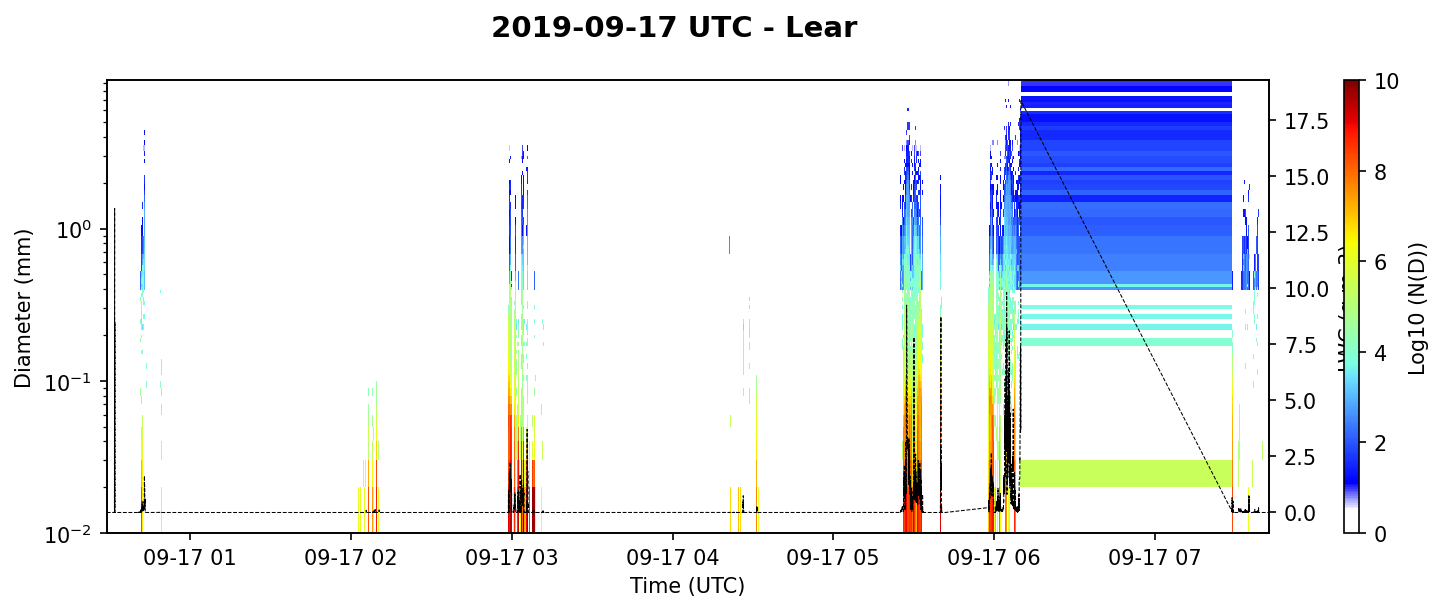

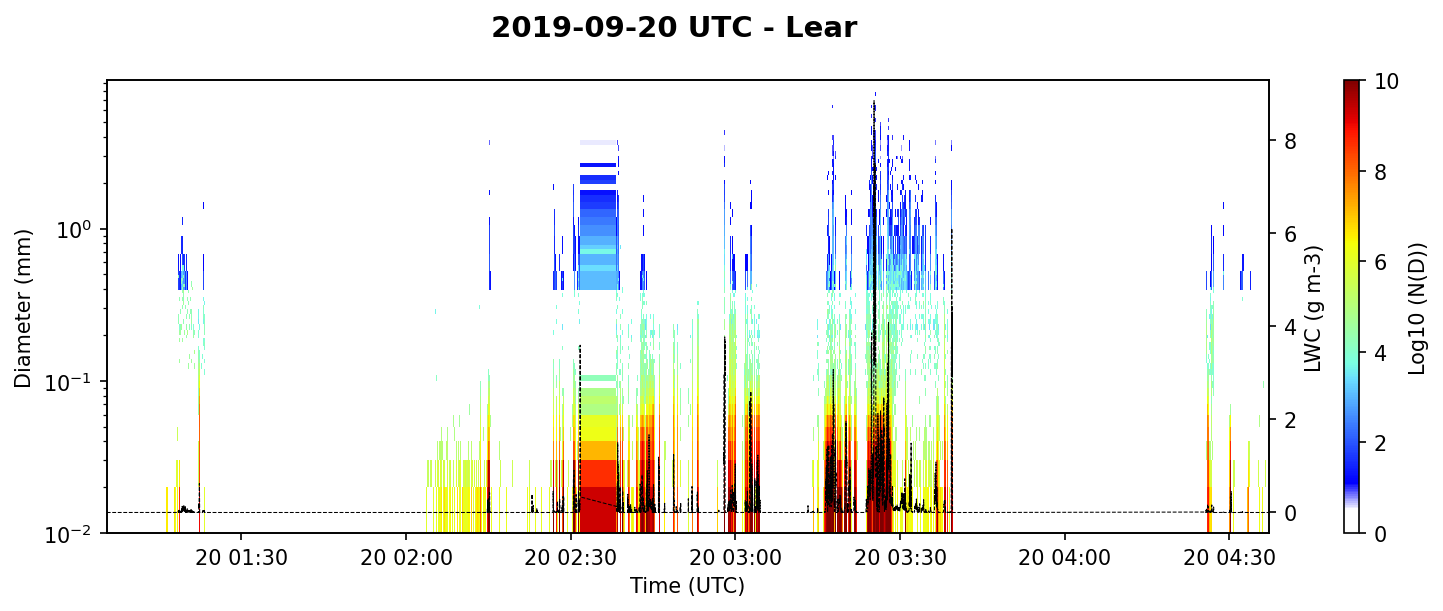

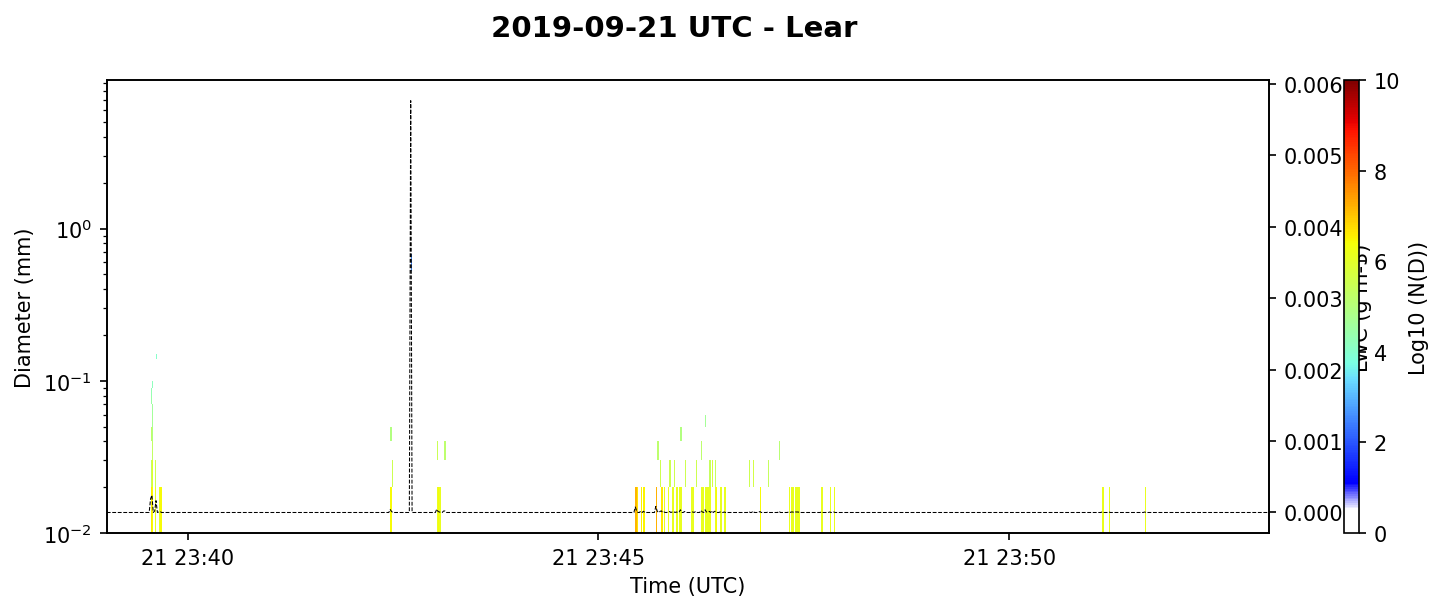

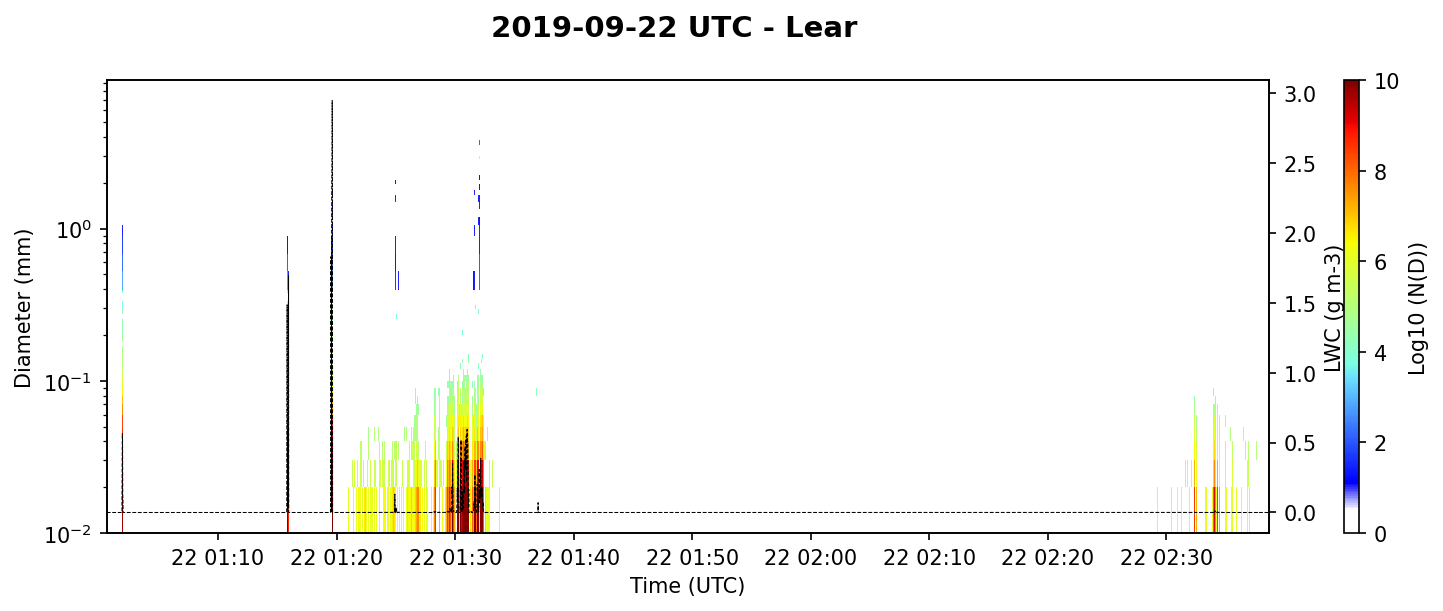

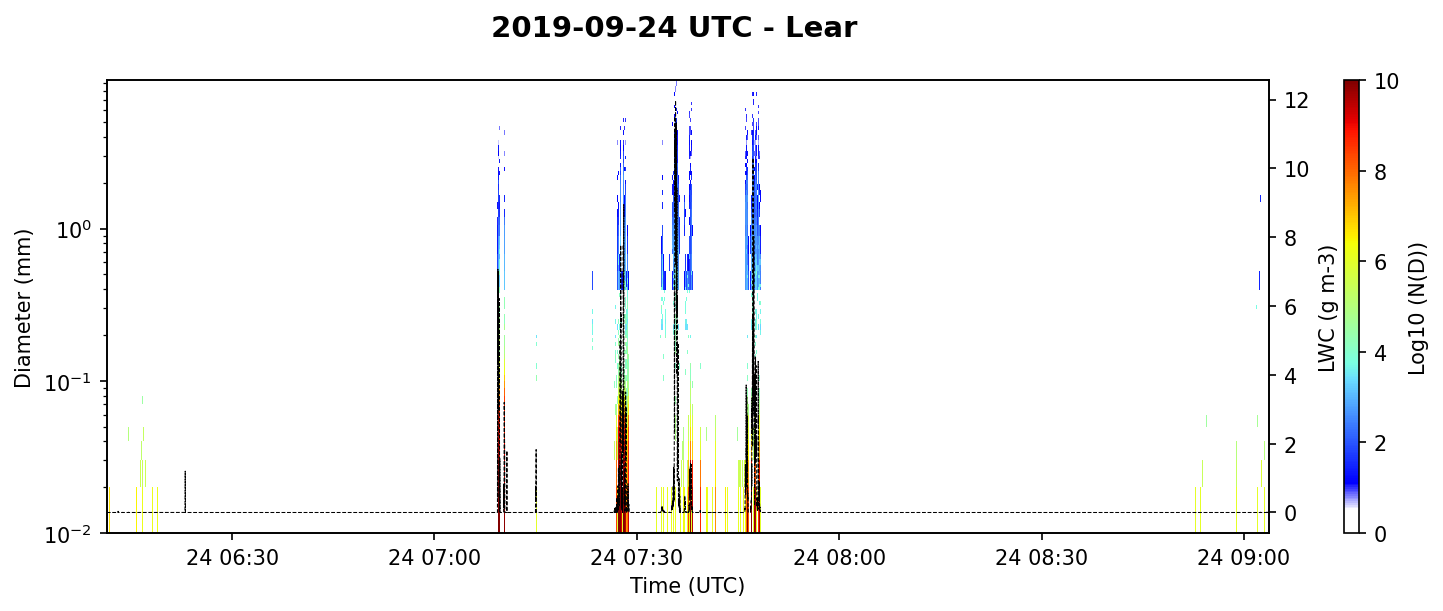

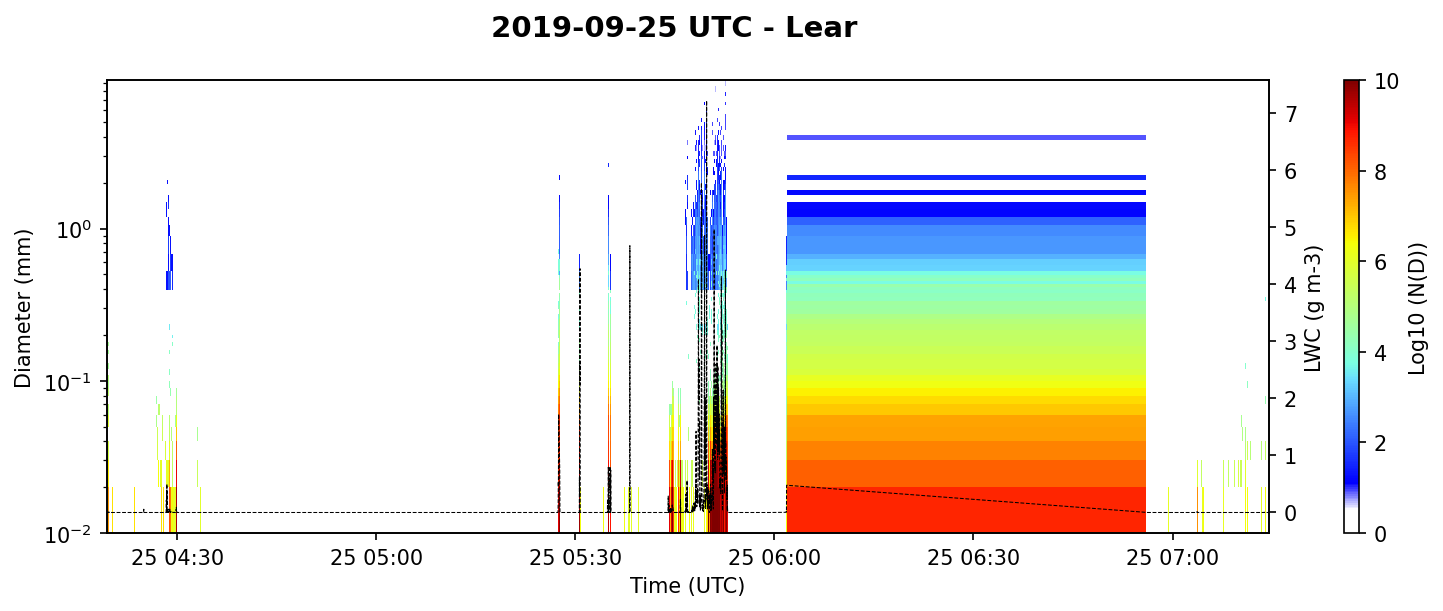

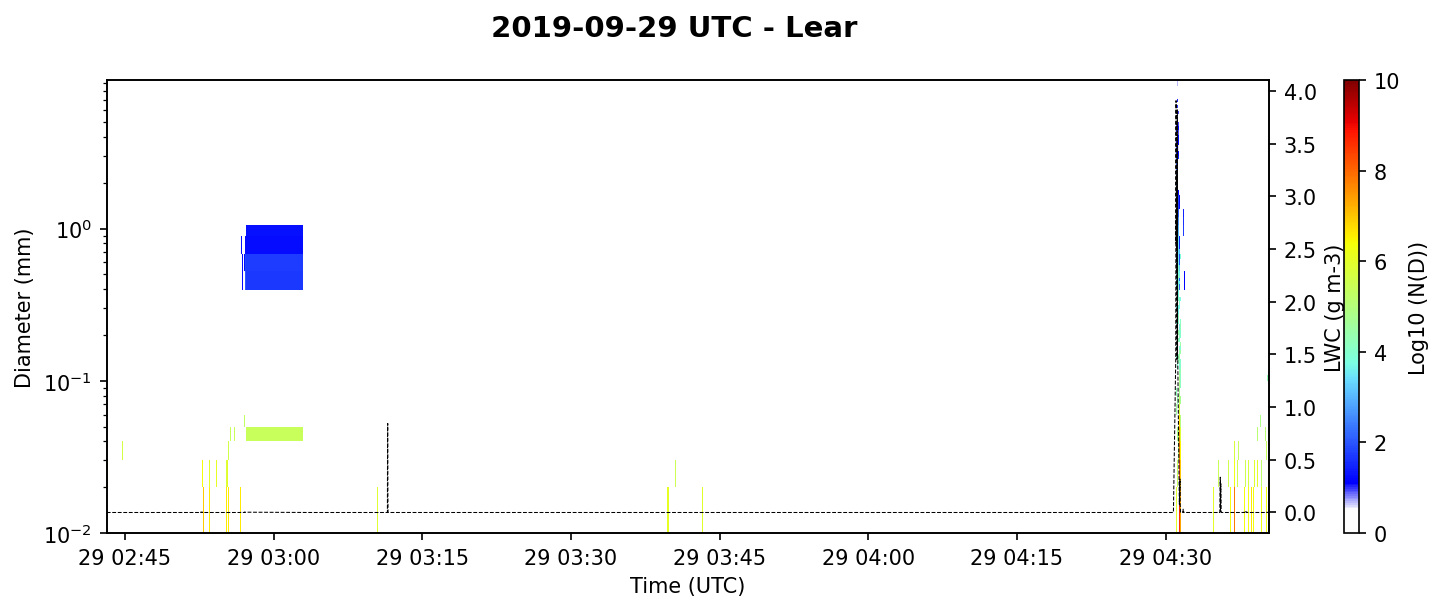

In [11]:
for _idx, data in xr_comb_350.where(xr_comb_350.psd > 0).sel(diameter=slice(0.001, 10)).groupby('time.day'):

    fig, ax1 = plt.subplots(figsize=(10, 4), dpi=150)
    cbar = ax1.pcolormesh(data.time.values, data.diameter, 
                   np.log10(data.psd.T.values), 
                      vmin=0, vmax=10, cmap=my_cmap)
    ax1.set_yscale('log')
    params = pds_parameters(data)
    ax11 = ax1.twinx()
    lwc_sum = data.lwc.sum('diameter')
    lwc_sum = lwc_sum.where(lwc_sum < 3500)
    ax11.plot(data.time, lwc_sum, c='k', ls='--', lw=0.5)
    add_colorbar_outside(cbar, ax1, 'Log10 (N(D))')
    ax1.set_xlabel('Time (UTC)')
    ax1.set_ylabel('Diameter (mm)')
    ax11.set_ylabel('LWC (g m-3)')
#     title = f"{pd.to_datetime(data.time.values[0]): %Y-%m-%d} UTC - {data.attrs['aircraft']}"
    title = f"{pd.to_datetime(data.time.values[0]): %Y-%m-%d} UTC - {aircraft}"
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)

In [59]:
event = xr_comb_350.sel(time=slice('2019-09-07 02:32:00', '2019-09-07 02:32:30')).\
sel(diameter=slice(0.001, 5))
parms_res = pds_parameters(event)

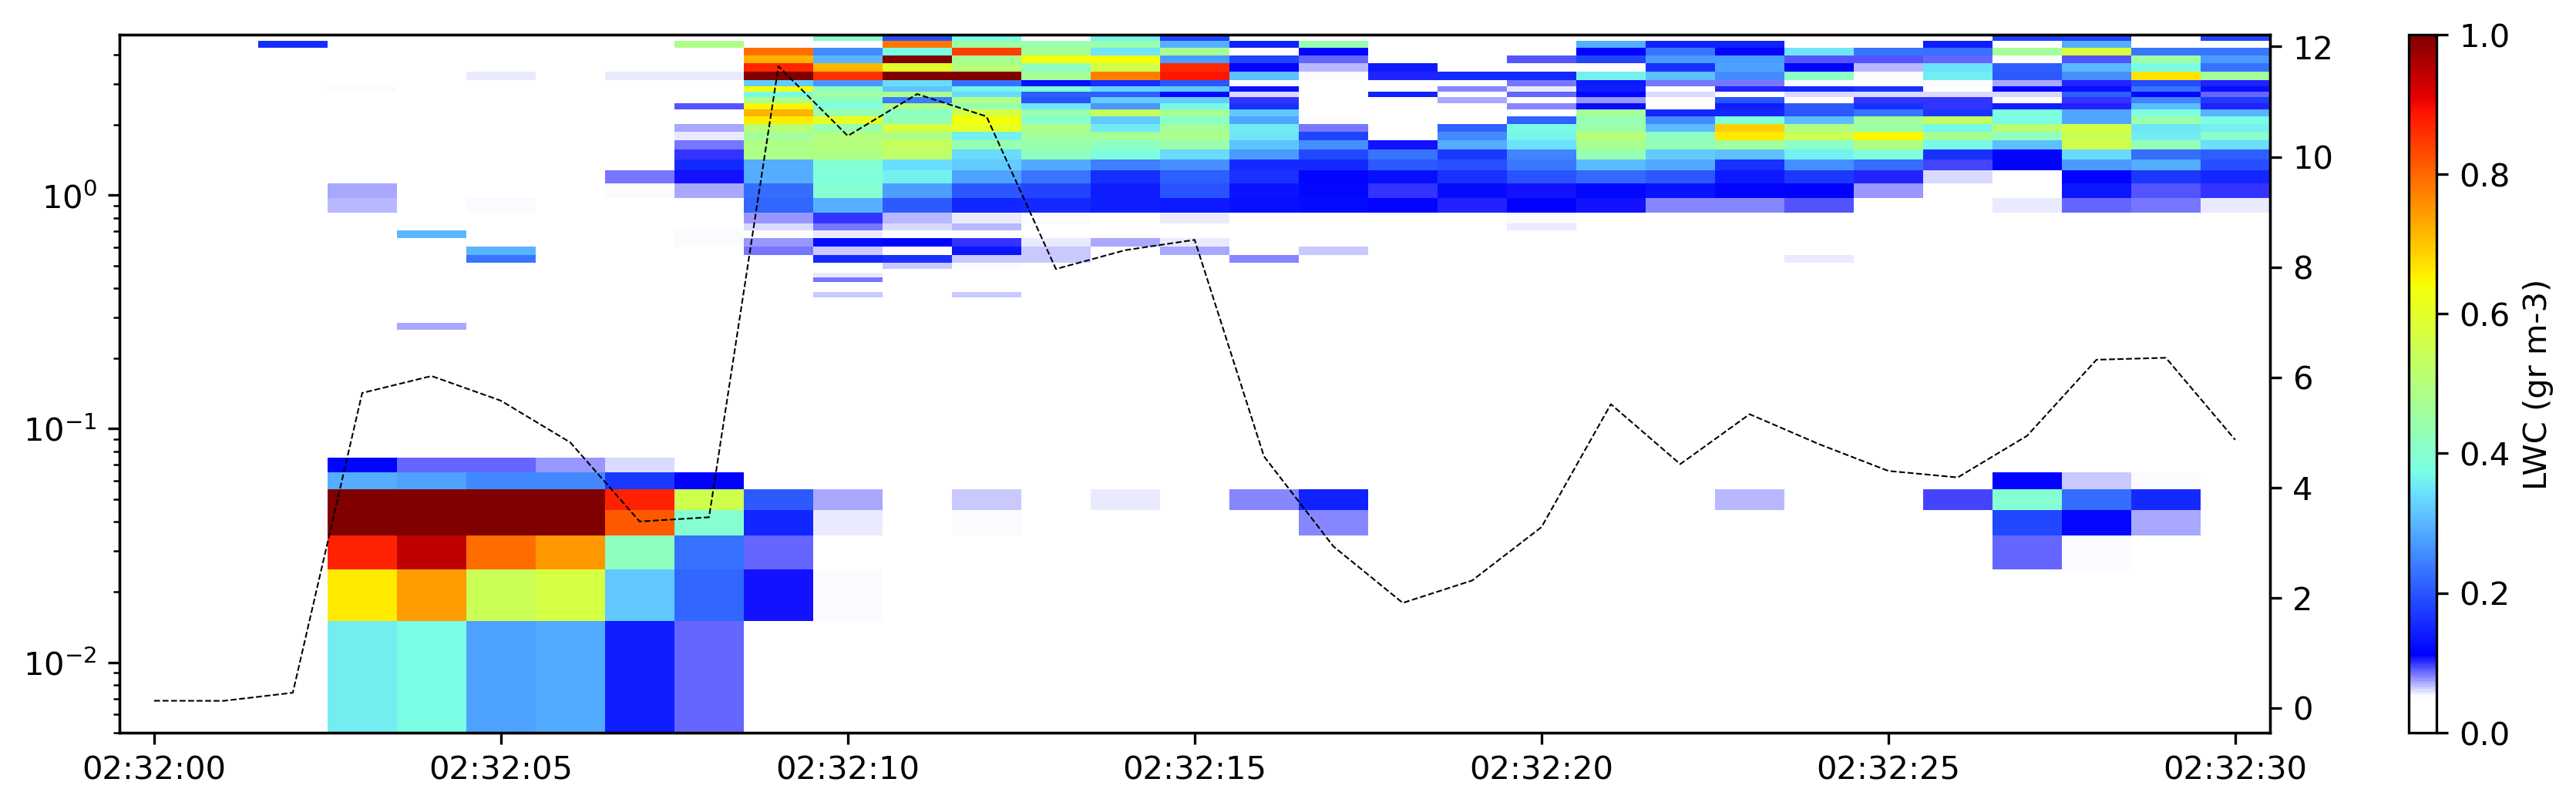

In [60]:
fig, ax = plt.subplots( figsize=(12,4), dpi=300, sharex=True)
cbar1 = ax.pcolormesh(event.time, 
                       event.diameter, 
                       event.lwc.T.values, 
                       vmin=0, vmax=1, cmap=my_cmap, shading='nearest')
ax11 = ax.twinx()
ax11.plot(event.time, event.lwc.sum('diameter'), c='k', ls='--', lw=0.5)

add_colorbar_outside(cbar1, ax, 'LWC (gr m-3)')
ax.set_yscale('log')
# ax.set_ylim(0.01, 10)

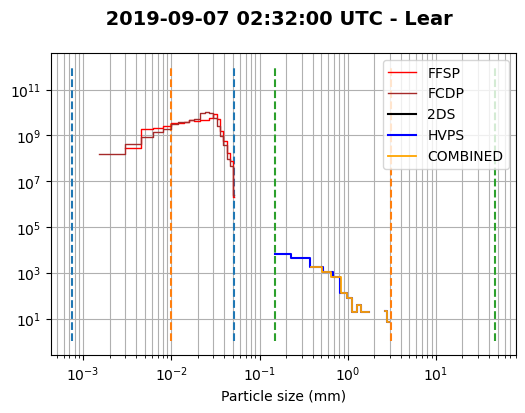

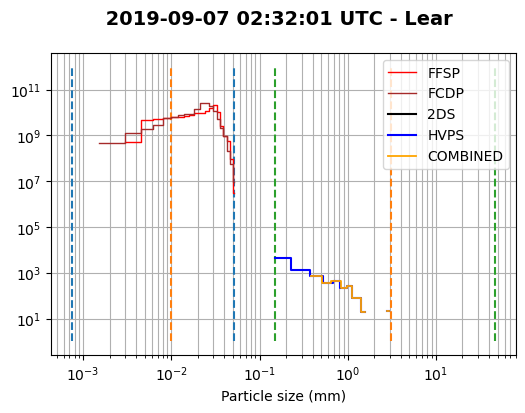

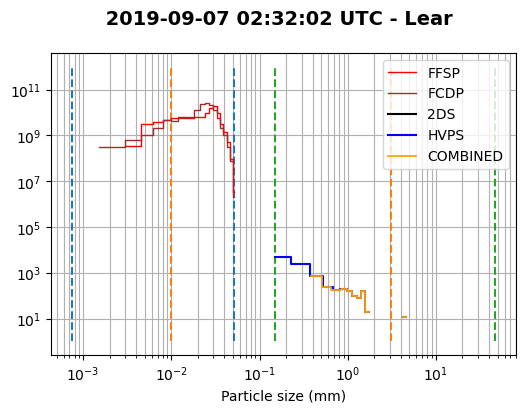

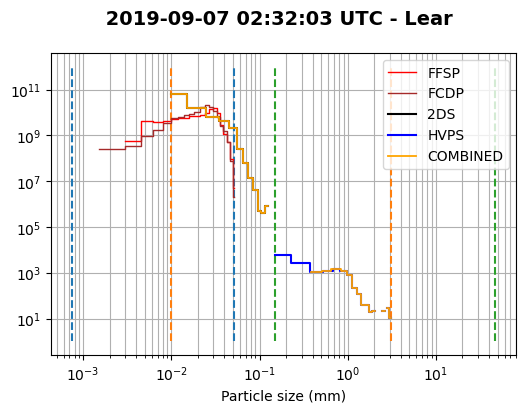

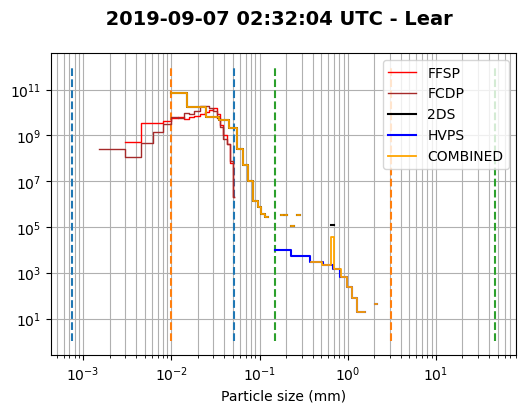

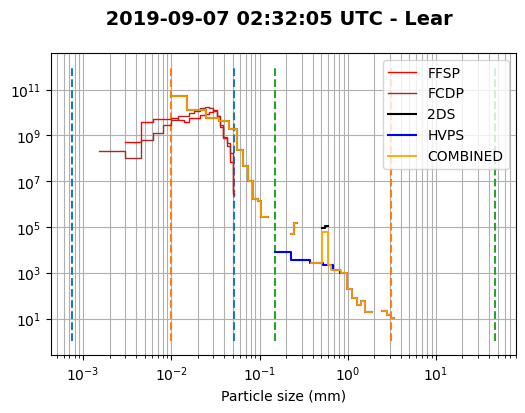

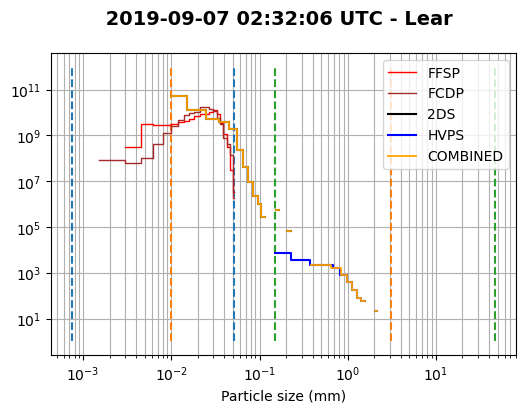

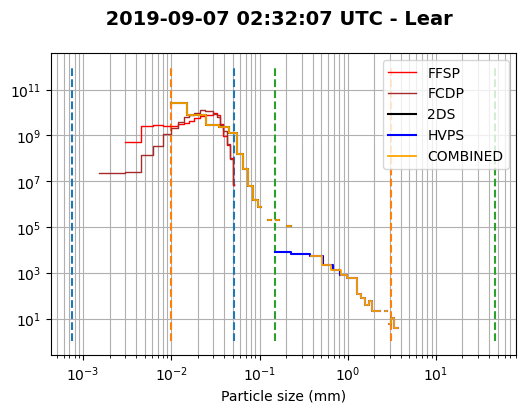

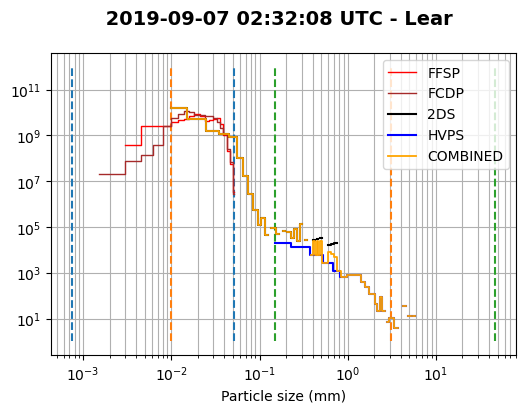

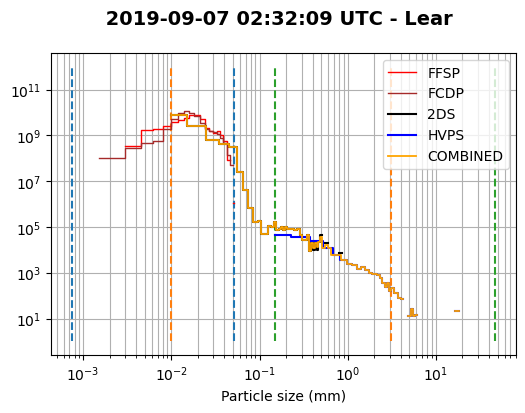

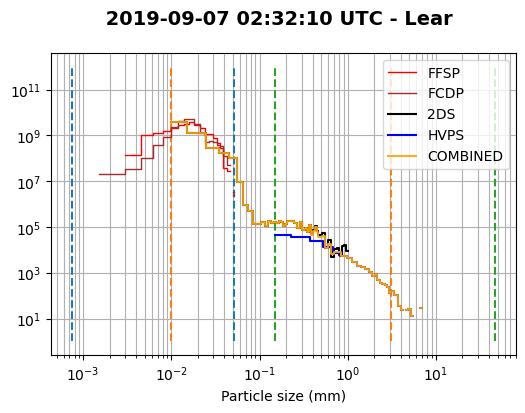

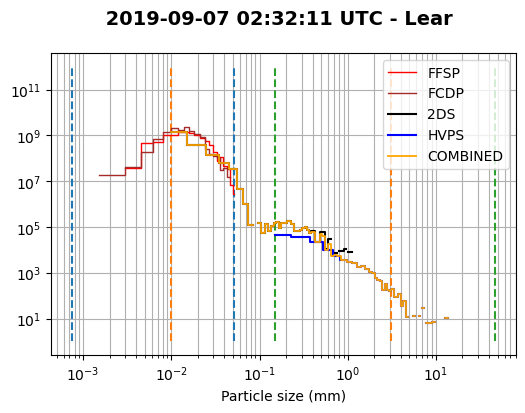

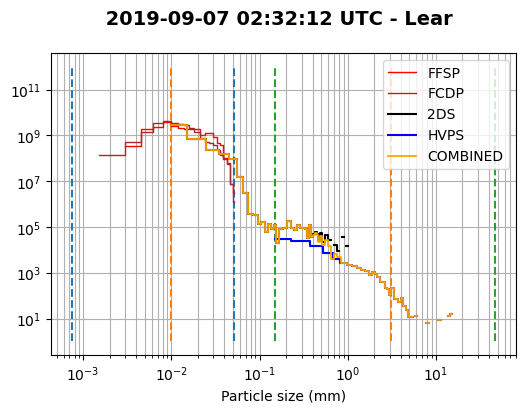

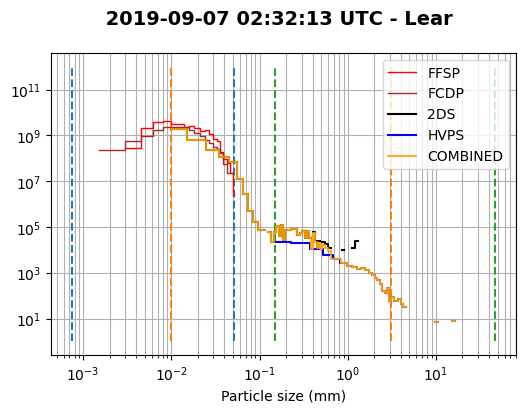

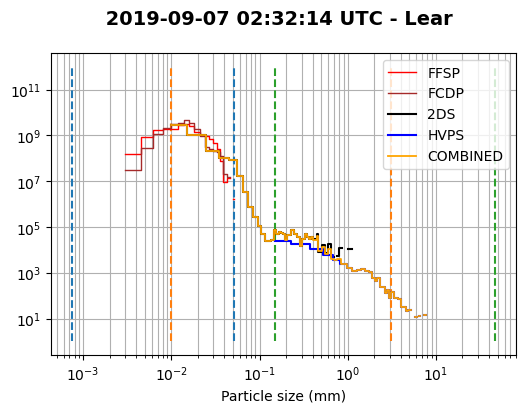

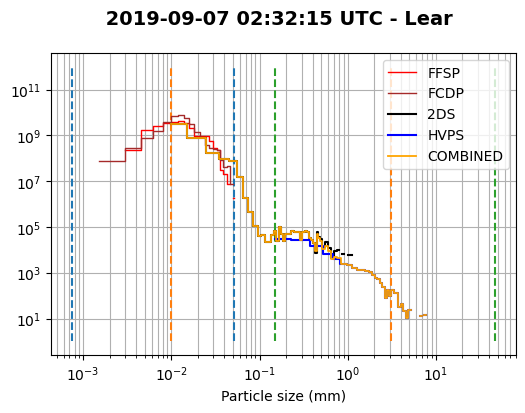

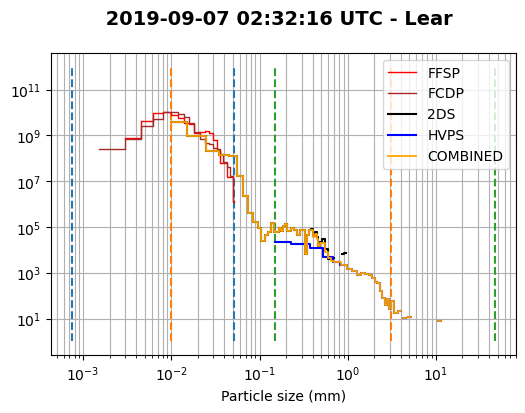

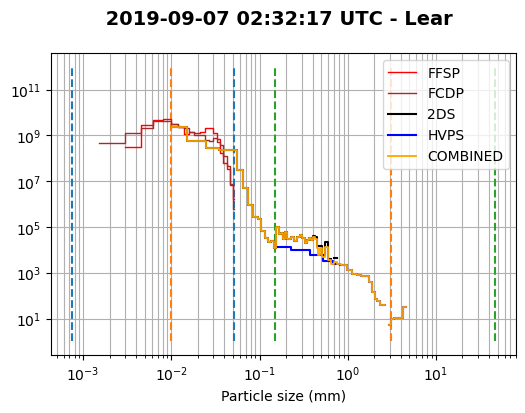

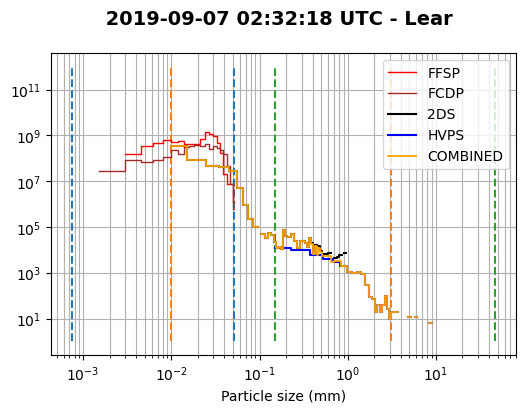

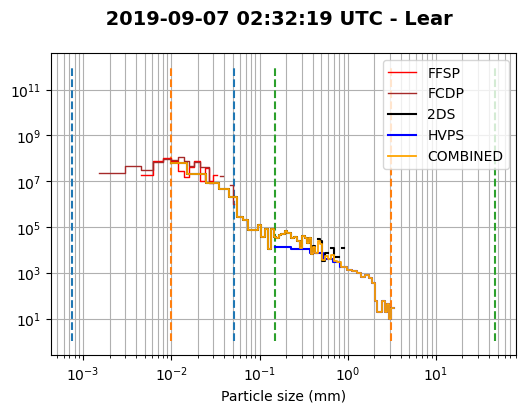

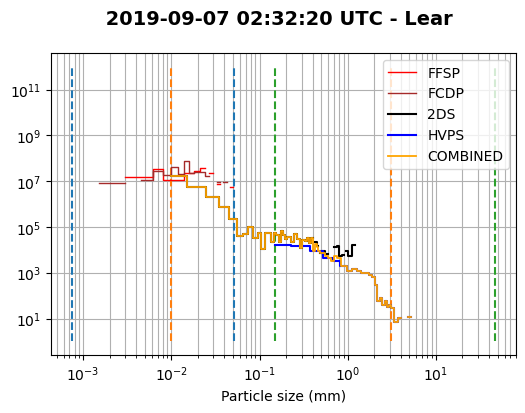

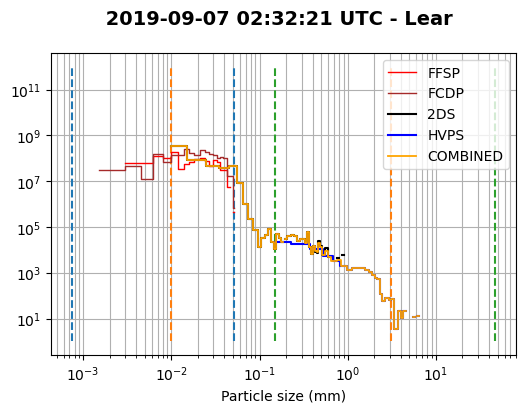

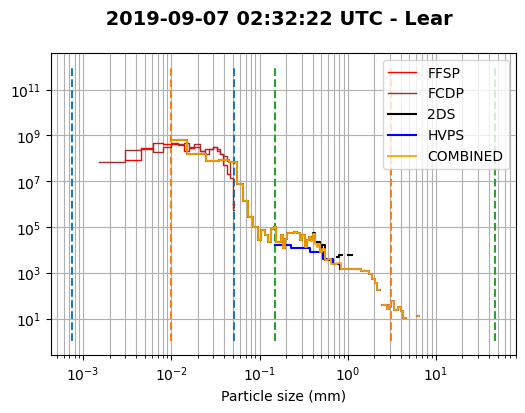

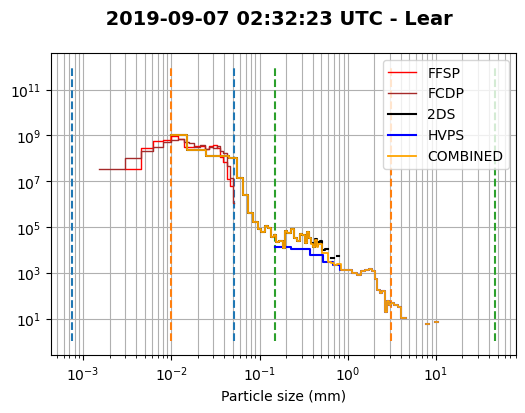

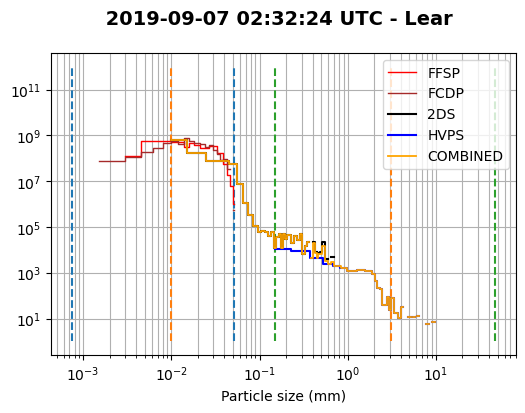

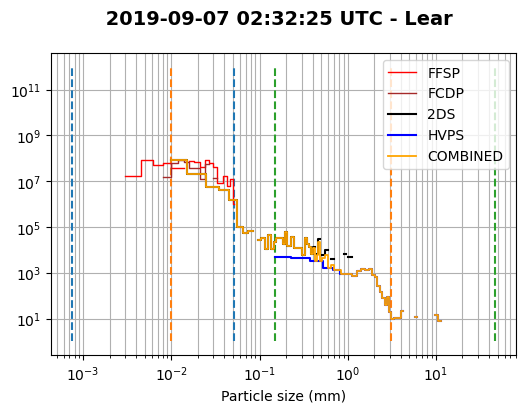

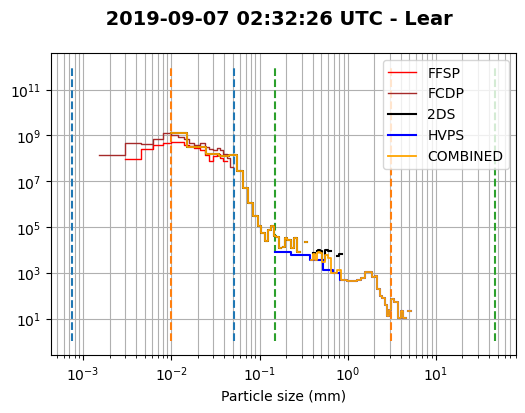

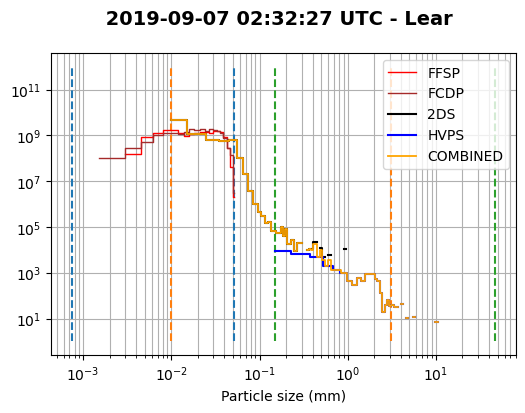

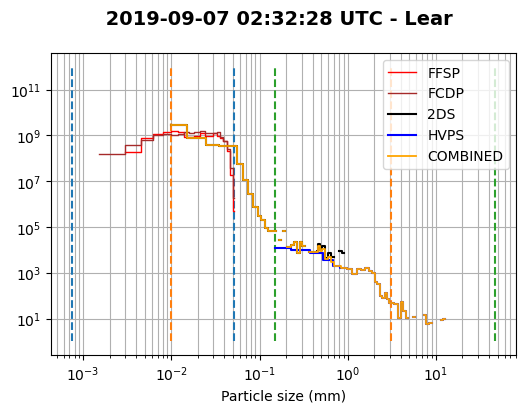

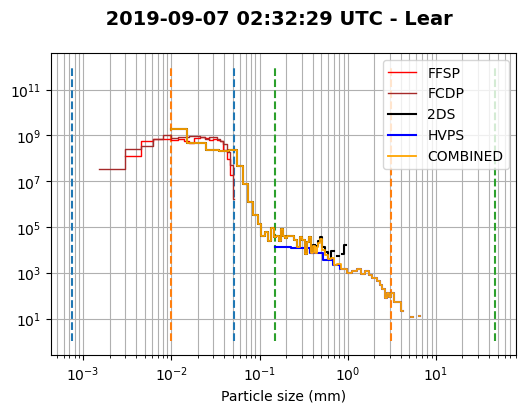

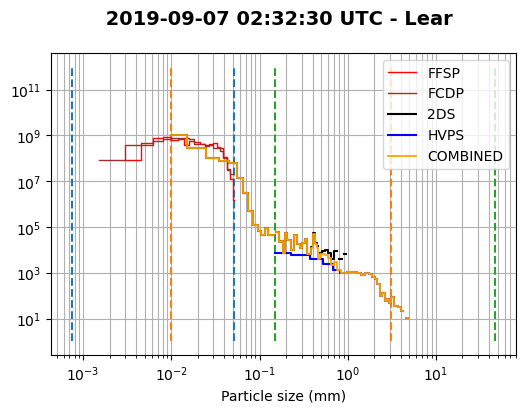

In [58]:
for i in xr_2ds.sel(time=slice('2019-09-07 02:32:00', '2019-09-07 02:32:30')).time:
    fig, ax1 = plt.subplots(dpi=100)
    
    y = xr_fssp.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)

    ax1.step(x=xr_fssp.diameter * 1e-3, y=y, where='mid', c='r', lw=1, label= 'FFSP')
    
    y = xr_fcdp.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)

    ax1.step(x=xr_fcdp.diameter * 1e-3, y=y, where='mid', c='brown', lw=1, label= 'FCDP')
    
    y = xr_2ds.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)

    ax1.step(x=xr_2ds.diameter * 1e-3, y=y, where='mid', label='2DS', c='k')

    y = xr_hvps.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)
    ax1.step(x=xr_hvps.diameter* 1e-3, y=y, where='mid', label='HVPS', c='b')
    
    y = xr_comb_350.psd.sel(time=i)
    y = y.where(y > 0, np.nan)
    ax1.step(x=xr_comb_350.diameter, y=y, where='mid', label='COMBINED', c='orange', lw=1.3)
    
    ax1.vlines(x=xr_fssp.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C0', linestyles='dashed')
    ax1.vlines(x=xr_fssp.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C0', linestyles='dashed')
    
    ax1.vlines(x=xr_2ds.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C1', linestyles='dashed')
    ax1.vlines(x=xr_2ds.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C1', linestyles='dashed')
    
    ax1.vlines(x=xr_hvps.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C2', linestyles='dashed')
    ax1.vlines(x=xr_hvps.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C2', linestyles='dashed')
    
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.legend()

    ax1.set_xlabel('Particle size (mm)')
    title = f"{pd.to_datetime(i.values): %Y-%m-%d %X} UTC - {aircraft}"
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
#     ax1.set_ylabel('Concentration (# m-3 m-1)')
    ax1.grid(which='both')
    ax.grid(which='both')
    plt.show()

In [45]:
event = xr_comb_350.sel(time=slice('2019-09-09 00:55:00', '2019-09-09 00:57:00')).\
sel(diameter=slice(0.001, 20))

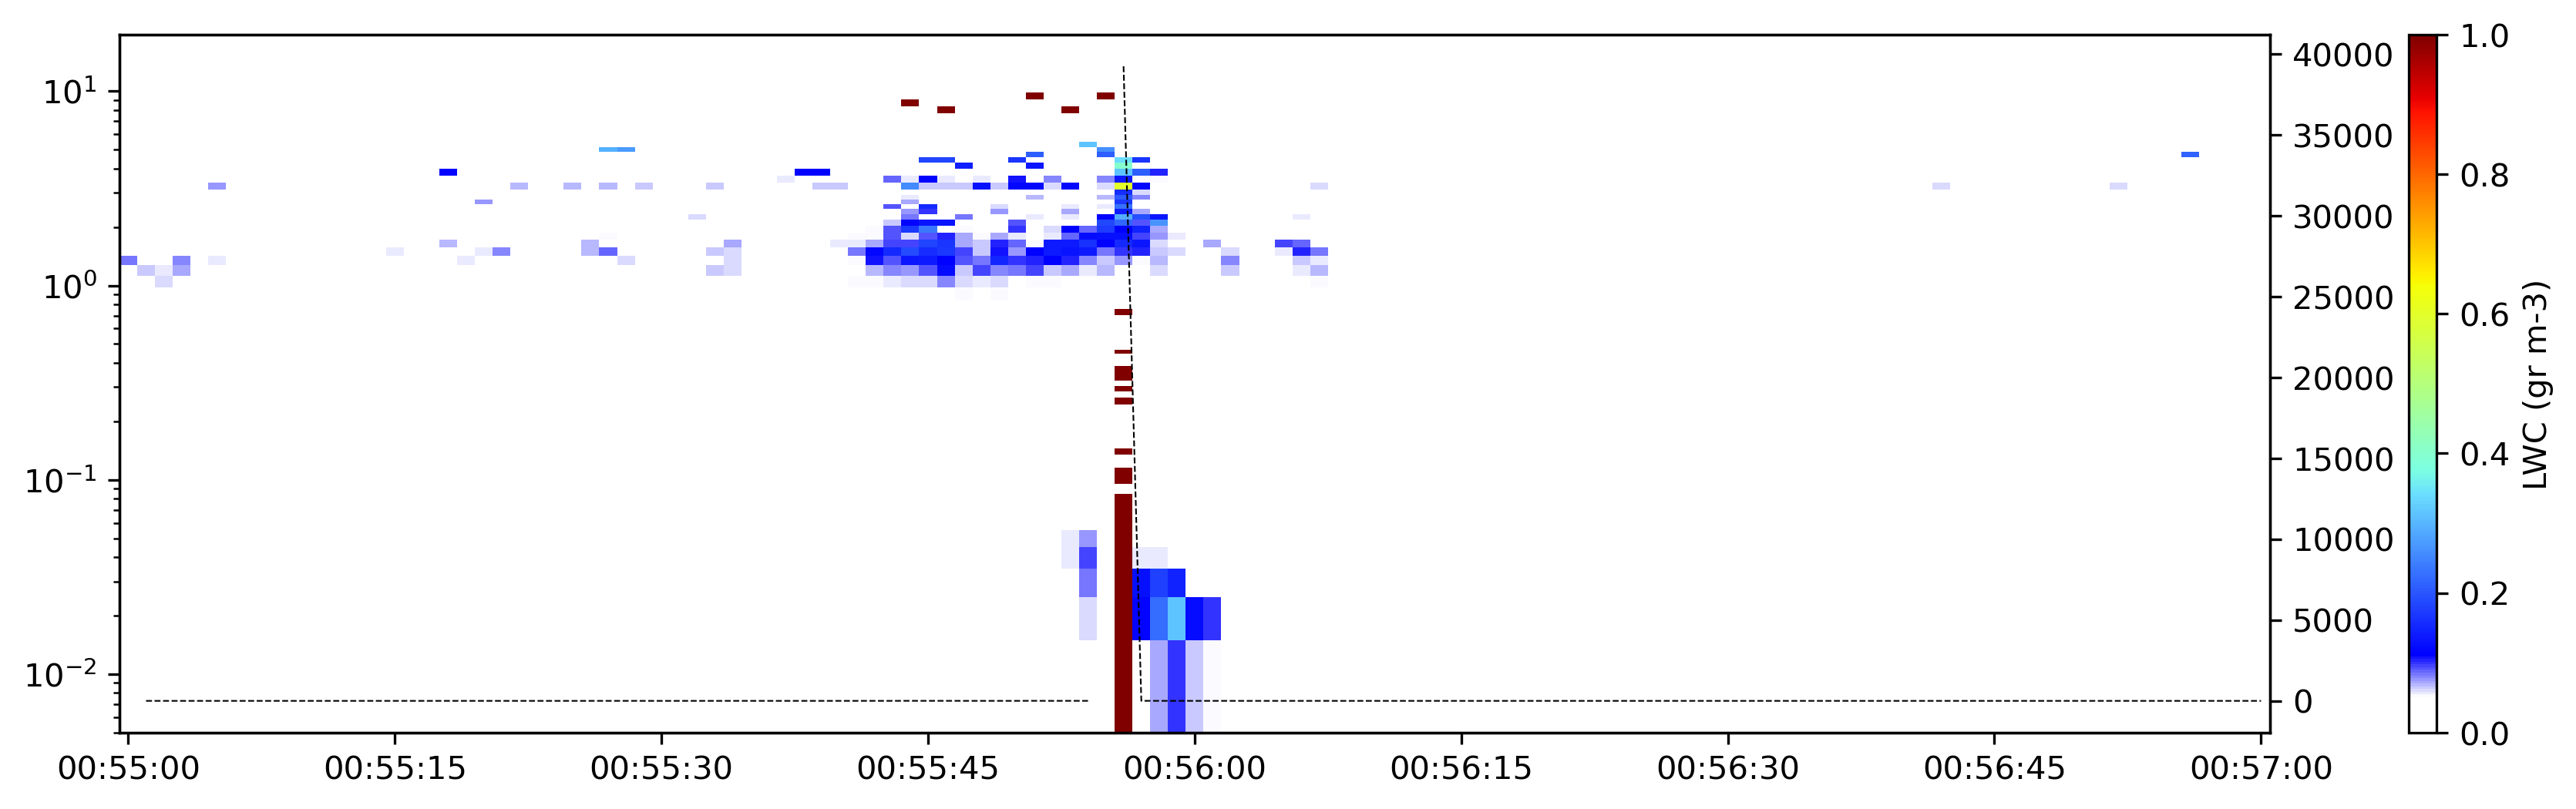

In [46]:
fig, ax = plt.subplots( figsize=(12,4), dpi=300, sharex=True)
cbar1 = ax.pcolormesh(event.time, 
                       event.diameter, 
                       event.lwc.T.values, 
                       vmin=0, vmax=1, cmap=my_cmap, shading='nearest')
ax11 = ax.twinx()
lwc = event.lwc.sum('diameter')
lwc = lwc.where(lwc > 0)
ax11.plot(event.time, lwc, c='k', ls='--', lw=0.5)

add_colorbar_outside(cbar1, ax, 'LWC (gr m-3)')
ax.set_yscale('log')
# ax.set_ylim(0.01, 10)

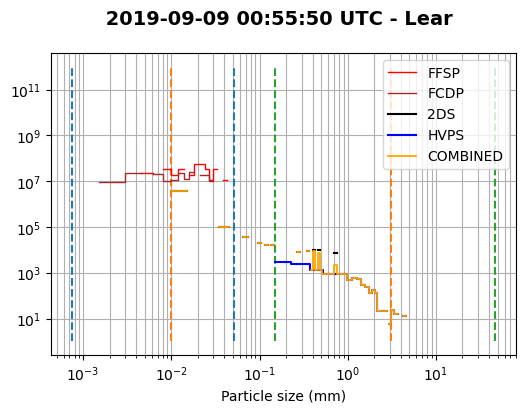

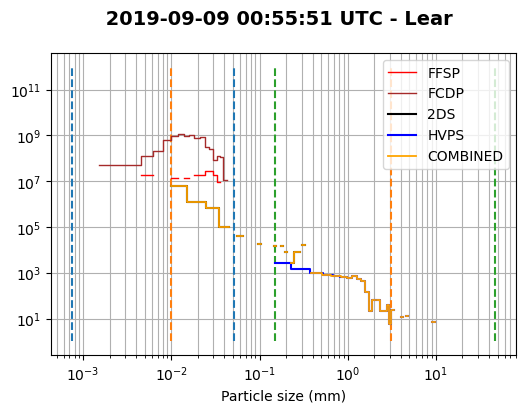

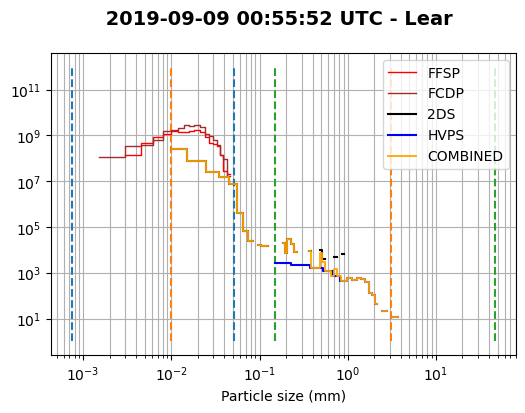

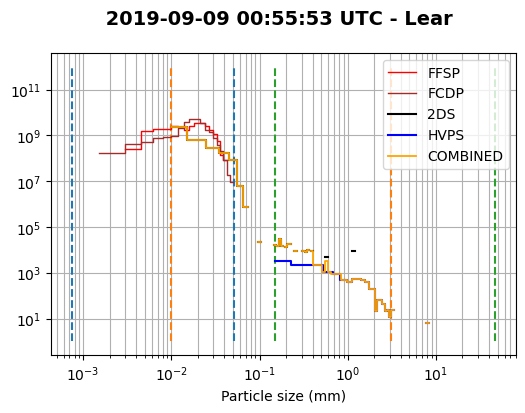

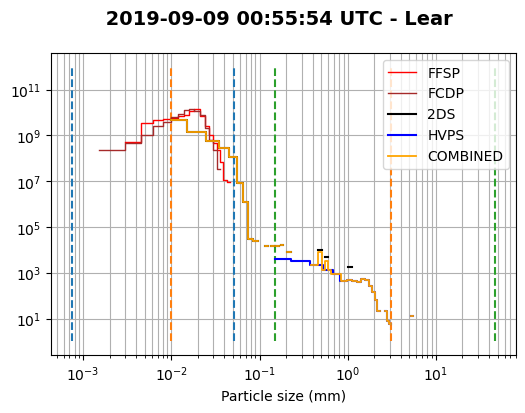

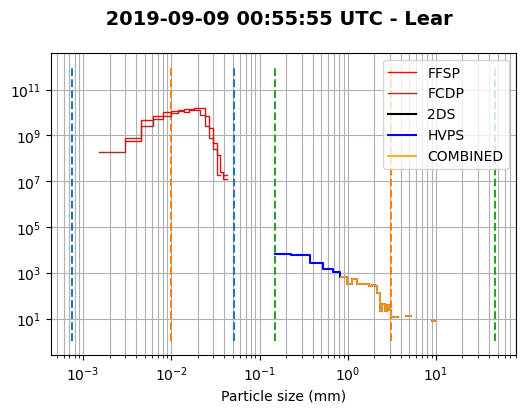

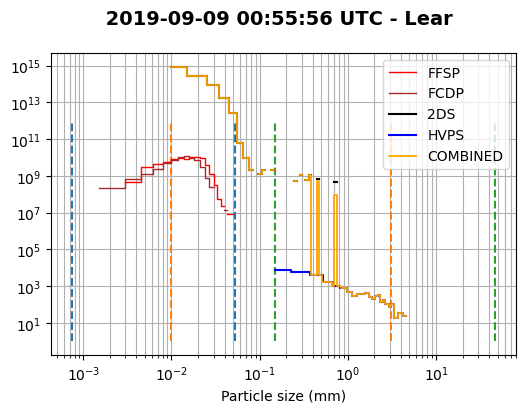

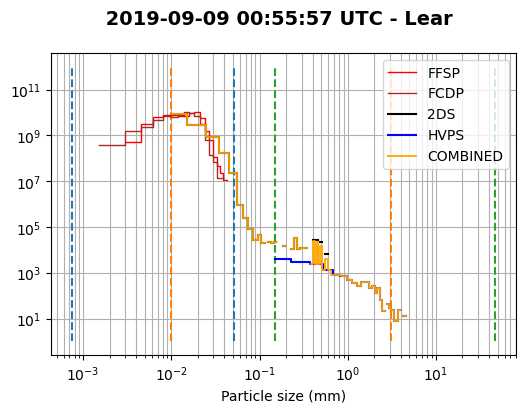

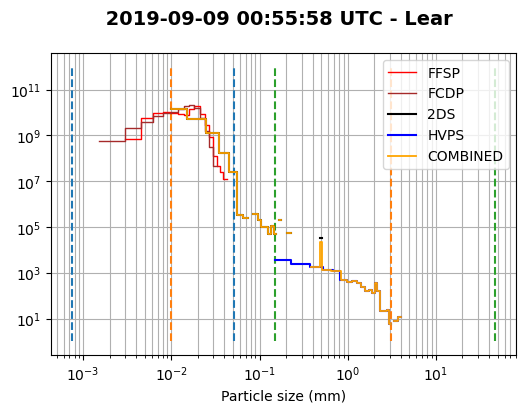

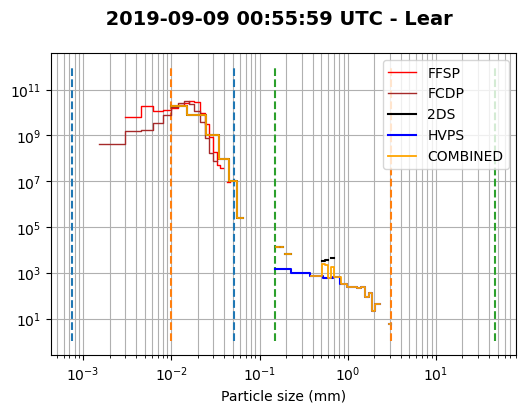

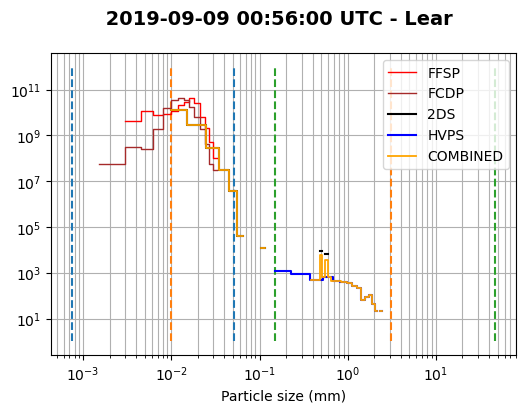

In [47]:
for i in xr_2ds.sel(time=slice('2019-09-09 00:55:50', '2019-09-09 00:56:00')).time:
    fig, ax1 = plt.subplots(dpi=100)
    
    y = xr_fssp.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)

    ax1.step(x=xr_fssp.diameter * 1e-3, y=y, where='mid', c='r', lw=1, label= 'FFSP')
    
    y = xr_fcdp.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)

    ax1.step(x=xr_fcdp.diameter * 1e-3, y=y, where='mid', c='brown', lw=1, label= 'FCDP')
    
    y = xr_2ds.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)

    ax1.step(x=xr_2ds.diameter * 1e-3, y=y, where='mid', label='2DS', c='k')

    y = xr_hvps.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)
    ax1.step(x=xr_hvps.diameter* 1e-3, y=y, where='mid', label='HVPS', c='b')
    
    y = xr_comb_350.psd.sel(time=i)
    y = y.where(y > 0, np.nan)
    ax1.step(x=xr_comb_350.diameter, y=y, where='mid', label='COMBINED', c='orange', lw=1.3)
    
    ax1.vlines(x=xr_fssp.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C0', linestyles='dashed')
    ax1.vlines(x=xr_fssp.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C0', linestyles='dashed')
    
    ax1.vlines(x=xr_2ds.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C1', linestyles='dashed')
    ax1.vlines(x=xr_2ds.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C1', linestyles='dashed')
    
    ax1.vlines(x=xr_hvps.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C2', linestyles='dashed')
    ax1.vlines(x=xr_hvps.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C2', linestyles='dashed')
    
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.legend()

    ax1.set_xlabel('Particle size (mm)')
    title = f"{pd.to_datetime(i.values): %Y-%m-%d %X} UTC - {aircraft}"
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
#     ax1.set_ylabel('Concentration (# m-3 m-1)')
    ax1.grid(which='both')
    ax.grid(which='both')
    plt.show()

AttributeError: 'Dataset' object has no attribute 'lwc'

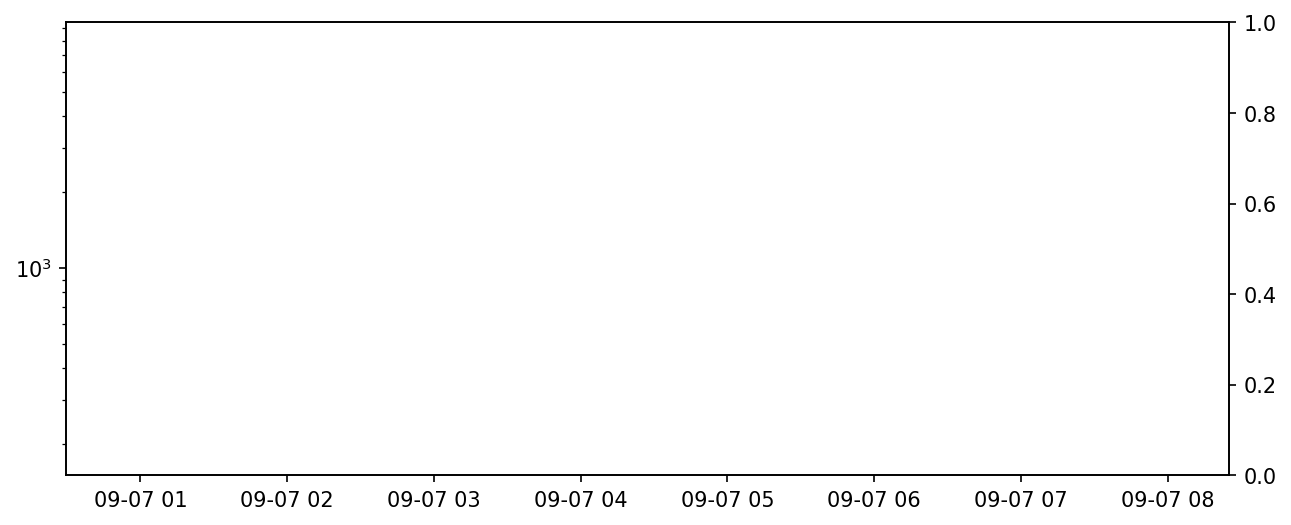

In [13]:
for _idx, data in xr_hvps.where(xr_hvps.psd > 0).sel(diameter=slice(100, 10000)).groupby('time.day'):
    fig, ax1 = plt.subplots(figsize=(10, 4), dpi=150)
    cbar = ax1.pcolormesh(data.time.values, data.diameter, 
                   np.log10(data.psd.T.values), 
                      vmin=0, vmax=10, cmap=my_cmap)
    ax1.set_yscale('log')
    params = pds_parameters(data)
    ax11 = ax1.twinx()
    lwc_sum = data.lwc.sum('diameter')
    lwc_sum = lwc_sum.where(lwc_sum < 3500)
    ax11.plot(data.time, lwc_sum, c='k', ls='--', lw=0.5)
    add_colorbar_outside(cbar, ax1, 'Log10 (N(D))')
    ax1.set_xlabel('Time (UTC)')
    ax1.set_ylabel('Diameter (mm)')
    ax11.set_ylabel('LWC (g m-3)')
#     title = f"{pd.to_datetime(data.time.values[0]): %Y-%m-%d} UTC - {data.attrs['aircraft']}"
    title = f"{pd.to_datetime(data.time.values[0]): %Y-%m-%d} UTC - {aircraft}"
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)